In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
import numpy as np

# colors
lakecolor = '#ca3e3dff' 
marinecolor = '#46556aff'
background = '#f8f6f4ff'
shading = '#e7e5e3ff'

In [ ]:
# Manual data (data from file 3.7 lake_ice_classification)
breakup = [
    "2014-05-24", "2015-06-21", "2016-05-13", "2017-05-25", "2018-05-29",
    "2019-05-09", "2020-05-21", "2021-05-02", "2022-05-18", "2023-05-16", "2024-05-15"
]

freezeup = [
    "2024-10-17", "2023-10-18", "2022-10-08", "2021-10-27", "2020-10-30",
    "2019-10-14", "2018-10-11", "2017-10-14", "2016-10-21", "2015-11-03", "2014-10-24"
]

# Reverse freezeup to align with breakup
freezeup.reverse()

# Convert dates to datetime
breakup_raw = [datetime.strptime(date, "%Y-%m-%d") for date in breakup]
freezeup_raw = [datetime.strptime(date, "%Y-%m-%d") for date in freezeup]
years = [d.year for d in breakup_raw]

# Normalize for plotting (use same dummy year)
breakup_dates = [d.replace(year=2000) for d in breakup_raw]
freezeup_dates = [d.replace(year=2000) for d in freezeup_raw]


In [3]:
# Print statistics on ice cover duration
durations = [(freezeup_raw[i] - breakup_raw[i]).days for i in range(len(years))]
durations_array = np.array(durations)

# Calculate ice-free period
ice_free_periods = 365 - durations_array

print(f"Ice-free period statistics (days):")
print(f"  Average: {ice_free_periods.mean():.1f}")
print(f"  Longest: {ice_free_periods.max()}")
print(f"  Shortest: {ice_free_periods.min()}")


Ice-free period statistics (days):
  Average: 212.5
  Longest: 230
  Shortest: 187


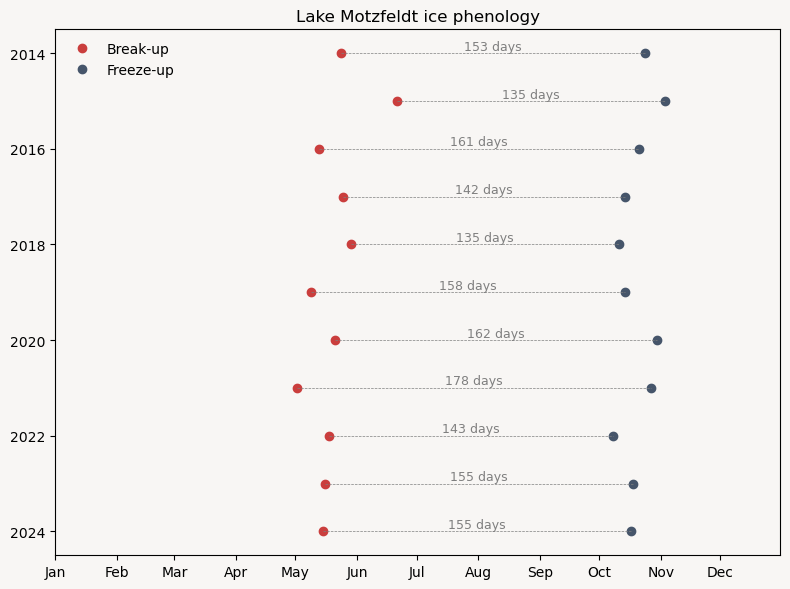

In [4]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor=background)

ax.set_facecolor(background)

# Plot break-up and freeze-up dates
ax.plot(breakup_dates, years, 'o', label='Break-up', color=lakecolor)
ax.plot(freezeup_dates, years, 'o', label='Freeze-up', color=marinecolor)

# Draw lines and add duration labels
for i in range(len(years)):
    x_start = breakup_dates[i]
    x_end = freezeup_dates[i]
    y = years[i]

    # Line between break-up and freeze-up
    ax.hlines(y, xmin=x_start, xmax=x_end, color='tab:gray', linestyles='dashed', linewidth=0.5) 

    # Calculate duration and add text label
    duration = (freezeup_raw[i] - breakup_raw[i]).days
    x_mid = x_start + (x_end - x_start) / 2
    ax.text(x_mid, y - 0.01, f"{duration} days", ha='center', va='bottom', fontsize=9, color='tab:gray')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])

# Formatting
ax.set_title("Lake Motzfeldt ice phenology", fontsize=12)
ax.invert_yaxis()
ax.legend(fontsize=10, frameon=False)
plt.tight_layout()
plt.show()


Plotting together with calving events

In [ ]:
LT1 = pd.read_csv(r"... \3.1_glacier_margins_and_flowline\LT_margins.csv", 
                      skiprows=2,
                      names = ["year", "month", "day", "serial_date", "pos_flowline", "pos_rel", "change","change_rate", "terminus_width", "path_length", "node_distance", "box_width", "box_area"]
                      )

LT1['date'] = pd.to_datetime(LT1['year'].astype(str) + '-' + LT1['month'].astype(str) + '-' + LT1['day'].astype(str))
LT1.index = LT1['date']
LT1.sort_index(inplace = True)

LT1['area_change'] = LT1['box_area'].diff()

In [ ]:
LT1_filtered = LT1[(LT1.index.year >= 2014) & (LT1.index.year <= 2024)]

# Extract major calving events
calving_events = LT1_filtered[LT1_filtered['change'] <= -50]

# Assign the midpoint date between the two dates
mid_dates = []
for calv_date in calving_events.index:
    previous_date = LT1_filtered.index[LT1_filtered.index.get_loc(calv_date) - 1]
    midpoint = previous_date + (calv_date - previous_date) / 2
    mid_dates.append(midpoint)

# Replace the index of calving_events with the calculated midpoints
calving_events.index = pd.to_datetime(mid_dates)

# Use absolute value of change to size markers
sizes = calving_events['change'].abs()

# scale for better visual effect
scaled_sizes = sizes * 0.3

# Normalize dates for plotting (keep month/day, force year to 2000)
calving_x = [ts.replace(year=2000) for ts in calving_events.index]
calving_y = calving_events.index.year

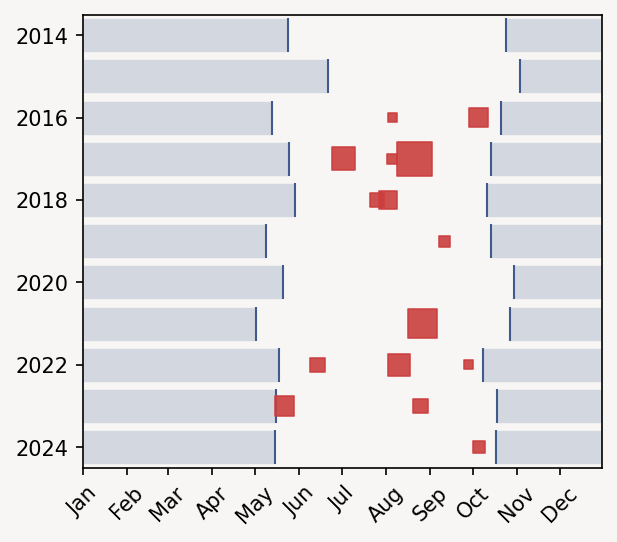

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(4, 3.5), dpi=150, facecolor=background, layout='constrained')

ax.set_facecolor(background)
lakecolor = '#ca3e3dff'
marinecolor = '#3f5b8eff'

# Plot break-up and freeze-up dates
ax.plot(breakup_dates, years, '|', label='Break-up', color=marinecolor, markersize=16)
ax.plot(freezeup_dates, years, '|', label='Freeze-up', color=marinecolor, markersize=16)

# Plot calving events
ax.scatter(
    calving_x,
    calving_y,
    s=scaled_sizes,
    facecolors=lakecolor,
    edgecolors=lakecolor,
    linewidths=0.8,
    alpha=0.9,
    label='Calving event',
    marker='s',
    zorder=5,
)

# Draw ice-free and frozen periods
for i in range(len(years)):
    y = years[i]
    
    # Ice-free period: January to break-up
    ax.hlines(y, xmin=datetime(2000, 1, 1), xmax=breakup_dates[i], 
              color=marinecolor, linewidth=16, alpha=0.2)
    
    # Frozen period: freeze-up to December
    ax.hlines(y, xmin=freezeup_dates[i], xmax=datetime(2000, 12, 31), 
              color=marinecolor, linewidth=16, alpha=0.2)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
ax.tick_params(axis='x', labelrotation=45)

# Invert y-axis
ax.invert_yaxis()

plt.show()

#fig.savefig(r'...path', dpi=300)